## Setup

### Import Statements

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import ttest_ind
from statannot import add_stat_annotation

import warnings
warnings.filterwarnings('ignore')

### Load in gender and age info of each subject

In [2]:
# read in average ICD values
gender_age_data = pd.read_csv('data/subject_demographics_595.txt',sep = '\t',names = ['subj_ID','age_months','gender'])
# display first 20 data values to check that read-in was successful
gender_age_data.head(5)

,subj_ID,age_months,gender
0,HCA6030645,544,F
1,HCA6031344,967,F
2,HCA6037457,880,F
3,HCA6051047,725,F
4,HCA6053758,437,F


### conn_vs_age_plot function:  
> displays visualization of connectivity values vs age linear and quadratic regression for each subject by gender, where red indicates women and blue indicates men; jointplots also generated to show datapoint distribution

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **y:** string variable stating the name of the ROI of interest
- **avg_or_peak:** string variable stating whether connectivity value inputs are "avg" or "peak" values from the VOI stats computation operation in BioImageSuite
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis

outputs:
- **figures** for linear and quadratic regressions, as well as jointplots, are saved into the directory specified within the function
- no variable outputs


In [3]:
def conn_vs_age_plot(df, y, avg_or_peak, icd_or_seed):
    sns.set(font_scale = 2)
    palette = sns.color_palette("bright")
    sns.set_style("white")
    
    # generate linear regression plots
    linear_lmplot = sns.lmplot(data = df, x = 'age', y = y, hue = 'gender', palette = [palette[3],palette[0]], scatter_kws = {"alpha": 0.2}, height=10, aspect=0.5)
    
    # stretch the y axis by factor of 2 but NOT standardizing across all ROIs
    axes = plt.gca()
    y_min, y_max = axes.get_ylim()
    print(y_min, y_max)
    
#     linear_lmplot.set(ylim=(y_min - ((y_max-y_min)/2), y_max + ((y_max-y_min)/2)))
    
    plt.title(y + " avg " + icd_or_seed + " values")
    plt.savefig("figures/" + icd_or_seed + "/" + avg_or_peak + "/figStretch_" + icd_or_seed + "_" + avg_or_peak + "_linear_" + y + ".png")
    plt.clf()
    
    # generate quadratic regression plots
#     quadratic_lmplot = sns.lmplot(data = df, x = 'age', y = y, hue = 'gender', palette = ['r', 'b'], order = 2, scatter_kws = {"alpha": 0.1})
#     plt.savefig("figures/" + icd_or_seed + "/" + avg_or_peak + "/" + icd_or_seed + "_" + avg_or_peak + "_quadratic_" + y + ".png")
#     plt.clf()

    # generate jointplots (to show data distribution across age)
#     dist_plot = sns.jointplot(data = df, x = 'age', y = y, hue = 'gender', palette = ['r', 'b'])
#     plt.savefig("figures/" + icd_or_seed + "/" + "jointplots/" + icd_or_seed + "_" + avg_or_peak + "_jointplot_" + y + ".png")
#     plt.clf()

### get_linear_r_p function:  
> collects Pearson correlation (R) values and corresponding p values for linear fits for each gender in the input ROI

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **y:** string variable stating the name of the ROI of interest
- **avg_or_peak:** string variable stating whether connectivity value inputs are "avg" or "peak" values from the VOI stats computation operation in BioImageSuite
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis

outputs:
- **r_f:** R for female linear regression in input ROI
- **p_f:** p value for female linear regression in input ROI
- **r_m:** R for male linear regression in input ROI
- **p_m:** p value for male linear regression in input ROI

In [4]:
def get_linear_r_p(df, y, avg_or_peak, icd_or_seed):
    r_f, p_f = sp.stats.pearsonr(df[df['gender'] == 'F']['age'], df[df['gender'] == 'F'][y])
    r_m, p_m = sp.stats.pearsonr(df[df['gender'] == 'M']['age'], df[df['gender'] == 'M'][y])
    return r_f, p_f, r_m, p_m

### get_quad_r2 function:  
> collects R squared values for quadratic fits for each gender in the input ROI

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **y:** string variable stating the name of the ROI of interest
- **avg_or_peak:** string variable stating whether connectivity value inputs are "avg" or "peak" values from the VOI stats computation operation in BioImageSuite
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis

outputs:
- **r2_f:** R squared for female quadratic regression in input ROI
- **r2_m:** R squared for male quadratic regression in input ROI

In [5]:
def get_quad_r2(df, y, avg_or_peak, icd_or_seed):
    
    #define function to calculate r-squared
    def polyfit(x, y):
        coeffs = np.polyfit(x, y, 2)
        p = np.poly1d(coeffs)
        #calculate r-squared
        yhat = p(x)
        ybar = np.sum(y)/len(y)
        ssreg = np.sum((yhat-ybar)**2)
        sstot = np.sum((y - ybar)**2)
        r_squared = ssreg / sstot

        return r_squared

    #find r-squared of polynomial model with degree = 2 (quadratic)
    r2_f = polyfit(df[df['gender'] == 'F']['age'], df[df['gender'] == 'F'][y])
    r2_m = polyfit(df[df['gender'] == 'M']['age'], df[df['gender'] == 'M'][y])
    
    return r2_f, r2_m

### get_lin_quad_data function:  

> collects linear and quadratic fit correlation data for each gender in the input ROI; implements *get_linear_r_p* and *get_quad_r2* functions

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **ROI:** string variable stating the name of the ROI of interest
- **ROI_num:** integer variable stating the number of the ROI of interest (corresponds with ROI number label in BIS objectmap)
- **avg_or_peak:** string variable stating whether connectivity value inputs are "avg" or "peak" values from the VOI stats computation operation in BioImageSuite
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis

outputs:
- **results:** pandas dataframe row holding the linear fit R and p values and quadratic fit R squared values for each gender

In [6]:
def get_lin_quad_data(df, ROI, ROI_num, avg_or_peak, icd_or_seed):
    lin_R_f, lin_p_f, lin_R_m, lin_p_m = get_linear_r_p(df, ROI, avg_or_peak, icd_or_seed)
    quad_R2_f, quad_R2_m = get_quad_r2(df, ROI, avg_or_peak, icd_or_seed)
    results = {'ROI_name':ROI, 'ROI_number':ROI_num,
               'linear_R_F':lin_R_f, 'linear_p_F':lin_p_f,
               'linear_R_M':lin_R_m, 'linear_p_M':lin_p_m,
               'quadratic_R2_F':quad_R2_f, 'quadratic_R2_M':quad_R2_m}
    
    return results

### conn_vs_age_boxplot function:  

> visualize connectivity data by decade comparing F vs M subjects for the input ROI; also displays mean of each group with green triangles and dashed lines connecting mean values across decades for each gender

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **y:** string variable stating the name of the ROI of interest
- **avg_or_peak:** string variable stating whether connectivity value inputs are "avg" or "peak" values from the VOI stats computation operation in BioImageSuite
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis
- **box_pair_list:** list of every comparison that the user wants displayed in the final figure (defined outside of this function, allows for exclusion of non-significant difference indicators)

outputs:
- **figures** of generated boxplots are saved into the directory specified within the function
- no variable outputs

In [110]:
def conn_vs_age_boxplot(df, y, icd_or_seed, box_pair_list):
    # shows the boxplots of women and men side by side, also shows the mean on top of boxplots
    df["age_group"] = pd.cut(df["age"], bins = range(30, 101, 10))
    
    gender_list = sorted(df['gender'].unique())
    age_group_list = sorted(df['age_group'].unique())
    
    df_F = df[df['gender'] == 'F']
    df_M = df[df['gender'] == 'M']
    m_F = df_F.groupby('age_group')[y].mean()
    m_M = df_M.groupby('age_group')[y].mean()
    
#     sns.set(rc={"figure.figsize":(5,10)})
    sns.set(font_scale = 1.8)
    palette = sns.color_palette("bright")
    sns.set_style("whitegrid")
    fig = sns.boxplot(data = df, x = "age_group", y = y, hue = "gender", 
                      showmeans = True, 
                      meanprops={"markersize":"15"},
                      palette = [palette[3],palette[0]])
    fig.set_title(y + " avg " + icd_or_seed + " values")

    # documentation for add_stat_annotation: https://github.com/webermarcolivier/statannot/blob/master/example/example.ipynb
        # to remove the Bonferroni correction, add this parameter: comparisons_correction=None
        # to remove p-value annotation legend and other info: verbose = 0 (otherwise, verbose = 2)
    
    # [BLOCK 1]***********************************************************************************************************************************************************************************************
    ## use this block if list of comparisons should be defined inside the function (aka, significant different indicators are desired for every decade group);
    ## otherwise, copy/paste this outside of the function implementation and delete necessary comparisons, comment out this block, and uncomment BLOCK 2
    
    # add_stat_annotation(fig, data=df, x = "age_group", y = y, hue = "gender", 
    #                     box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
    #                                ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
    #                                ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
    #                                ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
    #                                ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1])),
    #                                ((age_group_list[5], gender_list[0]), (age_group_list[5], gender_list[1])),
    #                                ((age_group_list[6], gender_list[0]), (age_group_list[6], gender_list[1]))],
    #                     test='t-test_ind', text_format='star', loc='inside', verbose=2, comparisons_correction=None)
    # ********************************************************************************************************************************************************************************************************
    
    # [BLOCK 2]***********************************************************************************************************************************************************************************************
    ## use this block if list of comparisons is specified outside of the function; 
    ## otherwise, comment this block and uncomment BLOCK 1
    add_stat_annotation(fig, data=df, x = "age_group", y = y, hue = "gender", box_pairs=box_pair_list, 
                        test='t-test_ind', text_format='star', loc='inside', verbose=0, comparisons_correction=None)
    # ********************************************************************************************************************************************************************************************************
    
    fig.plot([-0.2,.8,1.8,2.8,3.8,4.8,5.8],m_F.values,'r--', linewidth = 2)
    fig.plot([.2,1.2,2.2,3.2,4.2,5.2,6.2],m_M.values,'b--', linewidth = 2)
    
    lg = plt.legend(loc='upper left', bbox_to_anchor=(0.985, 1)).remove() # use .remove() at end of this line to get rid of legend
    
#     plt.savefig("figures/boxplots/figStretch_final_star_boxplot_" + icd_or_seed + "_" + y + ".png", bbox_extra_artists=(lg,), bbox_inches='tight')
#     plt.clf()

    return fig

### Create function to perform t-test comparing male and female connectivity data by decade
### ttest_age function:  

> perform t-test between female and male connectivity data by decade

inputs: 
- **df:** pandas dataframe containing columns for subject ID, age, gender, and columns for each ROI that connectivity values were collected for
- **y:** string variable stating the name of the ROI of interest
- **icd_or_seed:** string variable stating whether connectivity value inputs were derived from ICD or seed connectivity analysis

outputs:
- **ttest_values:** pandas dataframe row holding the age groups (decade), ROI names, t values, and corresponding p values

In [8]:
def ttest_age(df, y, icd_or_seed):

    # create dataframes in a dictionary for each decade
    d = {}
    keys = []
    for i in range(30,91,10):
        keys.append(str(i) + "_" + str(i + 10))
    age = 30
    for k in keys:
        d[k] = df[(df['age'] > age) & (df['age'] <= (age + 10))]
        age += 10

    # create dataframe to store all t and p values for each age group from t-test
    ttest_values = pd.DataFrame(columns = ['age_group', 'ROI', 't value', 'p value'])

    # populate t and p value dataframe
    age = 30
    for key, dataframe in d.items():
        age_str = str(age) + "_" + str(age + 10)
        t, p = ttest_ind(dataframe[dataframe['gender'] == 'F'][y], dataframe[dataframe['gender'] == 'M'][y])
        ttest_values = ttest_values.append({'age_group':age_str, 'ROI':y, 't value': t, 'p value': p}, ignore_index = True)
        age += 10
    # NOTE: warning will appear after running this for loop and 90_100 age group will have NaN for t and p values 
    # because there is only 1 man vs 4 women in that age group
    
    return ttest_values

# Female-Male ICD analysis (using average ICD values)

### Make list of ROIs of interest and their corresponding number labels

In [9]:
interest_ROIs = ["L_PCC", "L_AngGyr", "R_AngGyr", "L_Frontal", "R_Frontal", "L_MesiTemp", "R_MesiTemp"]
interest_ROI_nums = [20, 21, 18, 11, 10, 5, 6]

### Load in Female-Male average ICD values

In [10]:
# read in average ICD values derived from VOI Stats computation operation in BioImageSuite
icd_avg_data = pd.read_csv('data/ROI_FemaleMinusMale_DMNicdrestavg_alpha_n595_clust104p001_suyeonVOI_FULL.txt',sep = '\t',skip_blank_lines = True,skiprows = [1])
# display first 5 data values to check that read-in was successful
icd_avg_data.head(5)
# list all column names
# list(icd_avg_data.columns) 

,#Subj ID,Image Name,Task,R_lateraltemporal_medial_ROI1,L_lateraltemporal_ROI2,R_lateraltemporal_ROI3,L_lateraltemporal_medial_ROI4,L_mesialtemporal_ROI5,R_mesialtemporal_ROI6,L_frontal_ROI7,...,R_parietaloccipital_ROI16,R_PCCprecuneus_ROI17,R_angulargyrus_ROI18,L_parietaloccipital_ROI19,L_PCCprecuneus_ROI20,L_angulargyrus_ROI21,VOI 22,midline_PCCprecuneus_ROI23,L_parietal_ROI24,R_frontal_ROI25
0,HCA6030645,Common_HCA6030645_restavg_bis_icd_1_sqr_Both_...,Alpha,0.0309,0.0612,0.0581,0.0200,0.0387,0.0556,0.0139,...,0.0606,0.0272,0.0418,0.0387,0.0476,0.0434,0.0289,0.0771,0.0254,0.0482
1,HCA6031344,Common_HCA6031344_restavg_bis_icd_1_sqr_Both_...,Alpha,0.0455,0.0382,0.0326,0.0397,0.0318,0.0180,0.0526,...,0.0552,0.0398,0.0321,0.0585,0.0518,0.0393,0.0630,0.0861,0.0514,0.0265
2,HCA6037457,Common_HCA6037457_restavg_bis_icd_1_sqr_Both_...,Alpha,0.0234,0.0487,0.0562,0.0278,0.0248,0.0318,0.0439,...,0.0504,0.0410,0.0220,0.0598,0.0473,0.0095,0.0136,0.0744,0.0420,0.0261
3,HCA6051047,Common_HCA6051047_restavg_bis_icd_1_sqr_Both_...,Alpha,0.0436,0.0444,0.0517,0.0295,0.0473,0.0241,0.0253,...,0.0230,0.0422,0.0638,0.0277,0.0501,0.0567,0.0660,0.0850,0.0516,0.0454
4,HCA6053758,Common_HCA6053758_restavg_bis_icd_1_sqr_Both_...,Alpha,0.0476,0.0387,0.0325,0.0452,0.0382,0.0314,0.0200,...,0.0553,0.0359,0.0393,0.0456,0.0438,0.0370,0.0991,0.0584,0.0353,0.0467


### Make new dataframe with only necessary data from both read-in datasets

In [11]:
# create empty dataframe with necessary column names
master_data_avg_icd = pd.DataFrame(columns = ['subj_id','gender','age',
                                              'L_PCC','L_AngGyr','R_AngGyr','L_Frontal','R_Frontal','L_MesiTemp','R_MesiTemp'])

# add rows to dataframe (use exact column names from last code block)
master_data_avg_icd['subj_id'] = gender_age_data['subj_ID']
master_data_avg_icd['gender'] = gender_age_data['gender']
master_data_avg_icd['age'] = gender_age_data['age_months']/12
master_data_avg_icd['L_PCC'] = icd_avg_data[' L_PCCprecuneus_ROI20  ']
master_data_avg_icd['L_AngGyr'] = icd_avg_data[' L_angulargyrus_ROI21  ']
master_data_avg_icd['R_AngGyr'] = icd_avg_data[' R_angulargyrus_ROI18  ']
master_data_avg_icd['L_Frontal'] = icd_avg_data[' L_frontal_ROI11  ']
master_data_avg_icd['R_Frontal'] = icd_avg_data[' R_frontal_ROI10  ']
master_data_avg_icd['L_MesiTemp'] = icd_avg_data[' L_mesialtemporal_ROI5  ']
master_data_avg_icd['R_MesiTemp'] = icd_avg_data[' R_mesialtemporal_ROI6  ']

# display first 5 data values to check that dataframe was successfully generated
master_data_avg_icd.head(5)

,subj_id,gender,age,L_PCC,L_AngGyr,R_AngGyr,L_Frontal,R_Frontal,L_MesiTemp,R_MesiTemp
0,HCA6030645,F,45.333333,0.0476,0.0434,0.0418,0.0607,0.0754,0.0387,0.0556
1,HCA6031344,F,80.583333,0.0518,0.0393,0.0321,0.0420,0.0828,0.0318,0.0180
2,HCA6037457,F,73.333333,0.0473,0.0095,0.0220,0.0582,0.0625,0.0248,0.0318
3,HCA6051047,F,60.416667,0.0501,0.0567,0.0638,0.0600,0.0913,0.0473,0.0241
4,HCA6053758,F,36.416667,0.0438,0.0370,0.0393,0.0371,0.0802,0.0382,0.0314


### Plot the linear + quadratic regressions, and jointplots, for average ICD values vs. age with gender labels for each ROI of interest

In [12]:
for i in interest_ROIs:
    conn_vs_age_plot(master_data_avg_icd, i, "avg", "icd")

0.01817 0.06503
-0.004375 0.100675
-0.00435 0.09355
0.022255 0.11124500000000001
0.042175 0.146125
0.005755 0.07714499999999999
-0.0033699999999999997 0.07517


<Figure size 457.45x720 with 0 Axes>

<Figure size 457.45x720 with 0 Axes>

<Figure size 457.45x720 with 0 Axes>

<Figure size 457.45x720 with 0 Axes>

<Figure size 457.45x720 with 0 Axes>

<Figure size 457.45x720 with 0 Axes>

<Figure size 457.45x720 with 0 Axes>

### Get linear regression correlation info (R and p values) for each gender in each ROI

     ROI_name ROI_number  linear_R_F  linear_p_F  linear_R_M  linear_p_M  \
0       L_PCC         20    0.137991    0.010176    0.186548    0.003128   
1    L_AngGyr         21   -0.092777    0.084847    0.041480    0.514706   
2    R_AngGyr         18   -0.065074    0.227301    0.030436    0.632671   
3   L_Frontal         11    0.026363    0.625061    0.090614    0.153984   
4   R_Frontal         10    0.111360    0.038418    0.178367    0.004756   
5  L_MesiTemp          5    0.030377    0.573340   -0.058063    0.361570   
6  R_MesiTemp          6   -0.121930    0.023312   -0.066134    0.298586   

   quadratic_R2_F  quadratic_R2_M  
0        0.024215        0.034849  
1        0.008662        0.002034  
2        0.004450        0.008377  
3        0.000799        0.009784  
4        0.013028        0.035023  
5        0.002373        0.006064  
6        0.016698        0.006758  


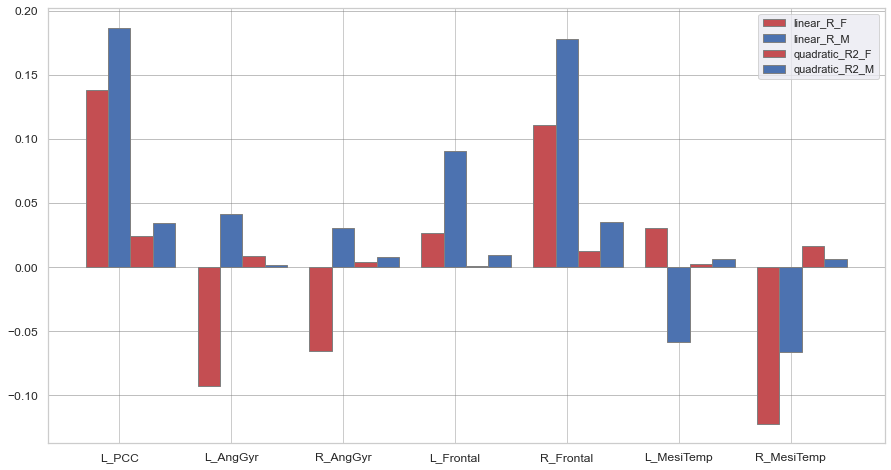

In [38]:
# create empty dataframe to store all linear and quadratic fits
lin_quad_fits_icd = pd.DataFrame(columns = ['ROI_name', 'ROI_number', 
                                            'linear_R_F', 'linear_p_F','linear_R_M', 'linear_p_M', 
                                            'quadratic_R2_F', 'quadratic_R2_M'])

# fill dataframe with linear r, quadratic r^2, and corresponding p values (for both linear and quadratic r's) for all ROIs
for i in range(len(interest_ROIs)):
    lin_quad_fits_icd = lin_quad_fits_icd.append(get_lin_quad_data(master_data_avg_icd, interest_ROIs[i], interest_ROI_nums[i], "avg", "icd"), ignore_index = True)

print(lin_quad_fits_icd)

# bar plot to visualize linear and quadratic regression correlation coeff data
barWidth = 0.20

br1 = np.arange(len(lin_quad_fits_icd['linear_R_F']))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

fig = plt.subplots(figsize =(15, 8))

sns.set(font_scale = 1)

plt.bar(br1, lin_quad_fits_icd['linear_R_F'], color ='r', width = barWidth, edgecolor ='grey', label ='linear_R_F')
plt.bar(br2, lin_quad_fits_icd['linear_R_M'], color ='b', width = barWidth, edgecolor ='grey', label ='linear_R_M')
plt.bar(br3, lin_quad_fits_icd['quadratic_R2_F'], color ='r', width = barWidth, edgecolor ='grey', label ='quadratic_R2_F')
plt.bar(br4, lin_quad_fits_icd['quadratic_R2_M'], color ='b', width = barWidth, edgecolor ='grey', label ='quadratic_R2_M')

plt.xticks([r + barWidth for r in range(len(lin_quad_fits_icd['linear_R_F']))], interest_ROIs)
plt.grid(color='gray', linewidth=1, axis='y', alpha=0.5)

plt.legend()
plt.show()


### Generate boxplots with p-value annotations/mean trend lines

In [37]:
master_data_avg_icd["age_group"] = pd.cut(master_data_avg_icd["age"], bins = range(30, 101, 10))

gender_list = sorted(master_data_avg_icd['gender'].unique())
age_group_list = sorted(master_data_avg_icd['age_group'].unique())

L_PCC_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                                   ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                                   ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                                   ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1]))]
conn_vs_age_boxplot(master_data_avg_icd, "L_PCC", "icd", L_PCC_box_pairs)

L_AngGyr_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                                   ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                                   ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                                   ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                                   ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1])),]
conn_vs_age_boxplot(master_data_avg_icd, "L_AngGyr", "icd", L_AngGyr_box_pairs)

R_AngGyr_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                                   ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                                   ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                                   ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                                   ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1]))]
conn_vs_age_boxplot(master_data_avg_icd, "R_AngGyr", "icd", R_AngGyr_box_pairs)

L_Frontal_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                                   ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                                   ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                                   ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                                   ((age_group_list[5], gender_list[0]), (age_group_list[5], gender_list[1]))]
conn_vs_age_boxplot(master_data_avg_icd, "L_Frontal", "icd", L_Frontal_box_pairs)

R_Frontal_box_pairs=[((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                                   ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                                   ((age_group_list[5], gender_list[0]), (age_group_list[5], gender_list[1]))]
conn_vs_age_boxplot(master_data_avg_icd, "R_Frontal", "icd", R_Frontal_box_pairs)

L_MesiTemp_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                                   ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                                   ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                                   ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                                   ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1])),
                                   ((age_group_list[5], gender_list[0]), (age_group_list[5], gender_list[1]))]
conn_vs_age_boxplot(master_data_avg_icd, "L_MesiTemp", "icd", L_MesiTemp_box_pairs)

R_MesiTemp_box_pairs=[((age_group_list[0], gender_list[0]), (age_group_list[0], gender_list[1])),
                                   ((age_group_list[1], gender_list[0]), (age_group_list[1], gender_list[1])),
                                   ((age_group_list[2], gender_list[0]), (age_group_list[2], gender_list[1])),
                                   ((age_group_list[3], gender_list[0]), (age_group_list[3], gender_list[1])),
                                   ((age_group_list[4], gender_list[0]), (age_group_list[4], gender_list[1]))]
conn_vs_age_boxplot(master_data_avg_icd, "R_MesiTemp", "icd", R_MesiTemp_box_pairs)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples, P_val=1.645e-05 stat=4.455e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples, P_val=3.021e-04 stat=3.826e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples, P_val=1.344e-05 stat=4.523e+00
(70, 80]_F v.s. (70, 80]_M: t-test independent samples, P_val=5.476e-04 stat=3.588e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

(40, 50]_F v.s. (40, 50]_M: t-test independent samples, P_val=1.684e-05 stat=4.449e+00
(30, 40]_F v.s. (30, 40]_M: t-test independent samples, P_val=2.795e-05 stat=4.519e+00
(50, 60]_F v.s. (50, 60]_M: t-test independent samples, P_val=2.641e-05 stat=4.356e+00
(60, 70]_F v.s. (60, 70]_M: t-test independent samples, P_val=3

<Figure size 360x720 with 0 Axes>

### Finalize boxplot figure arrangement for paper

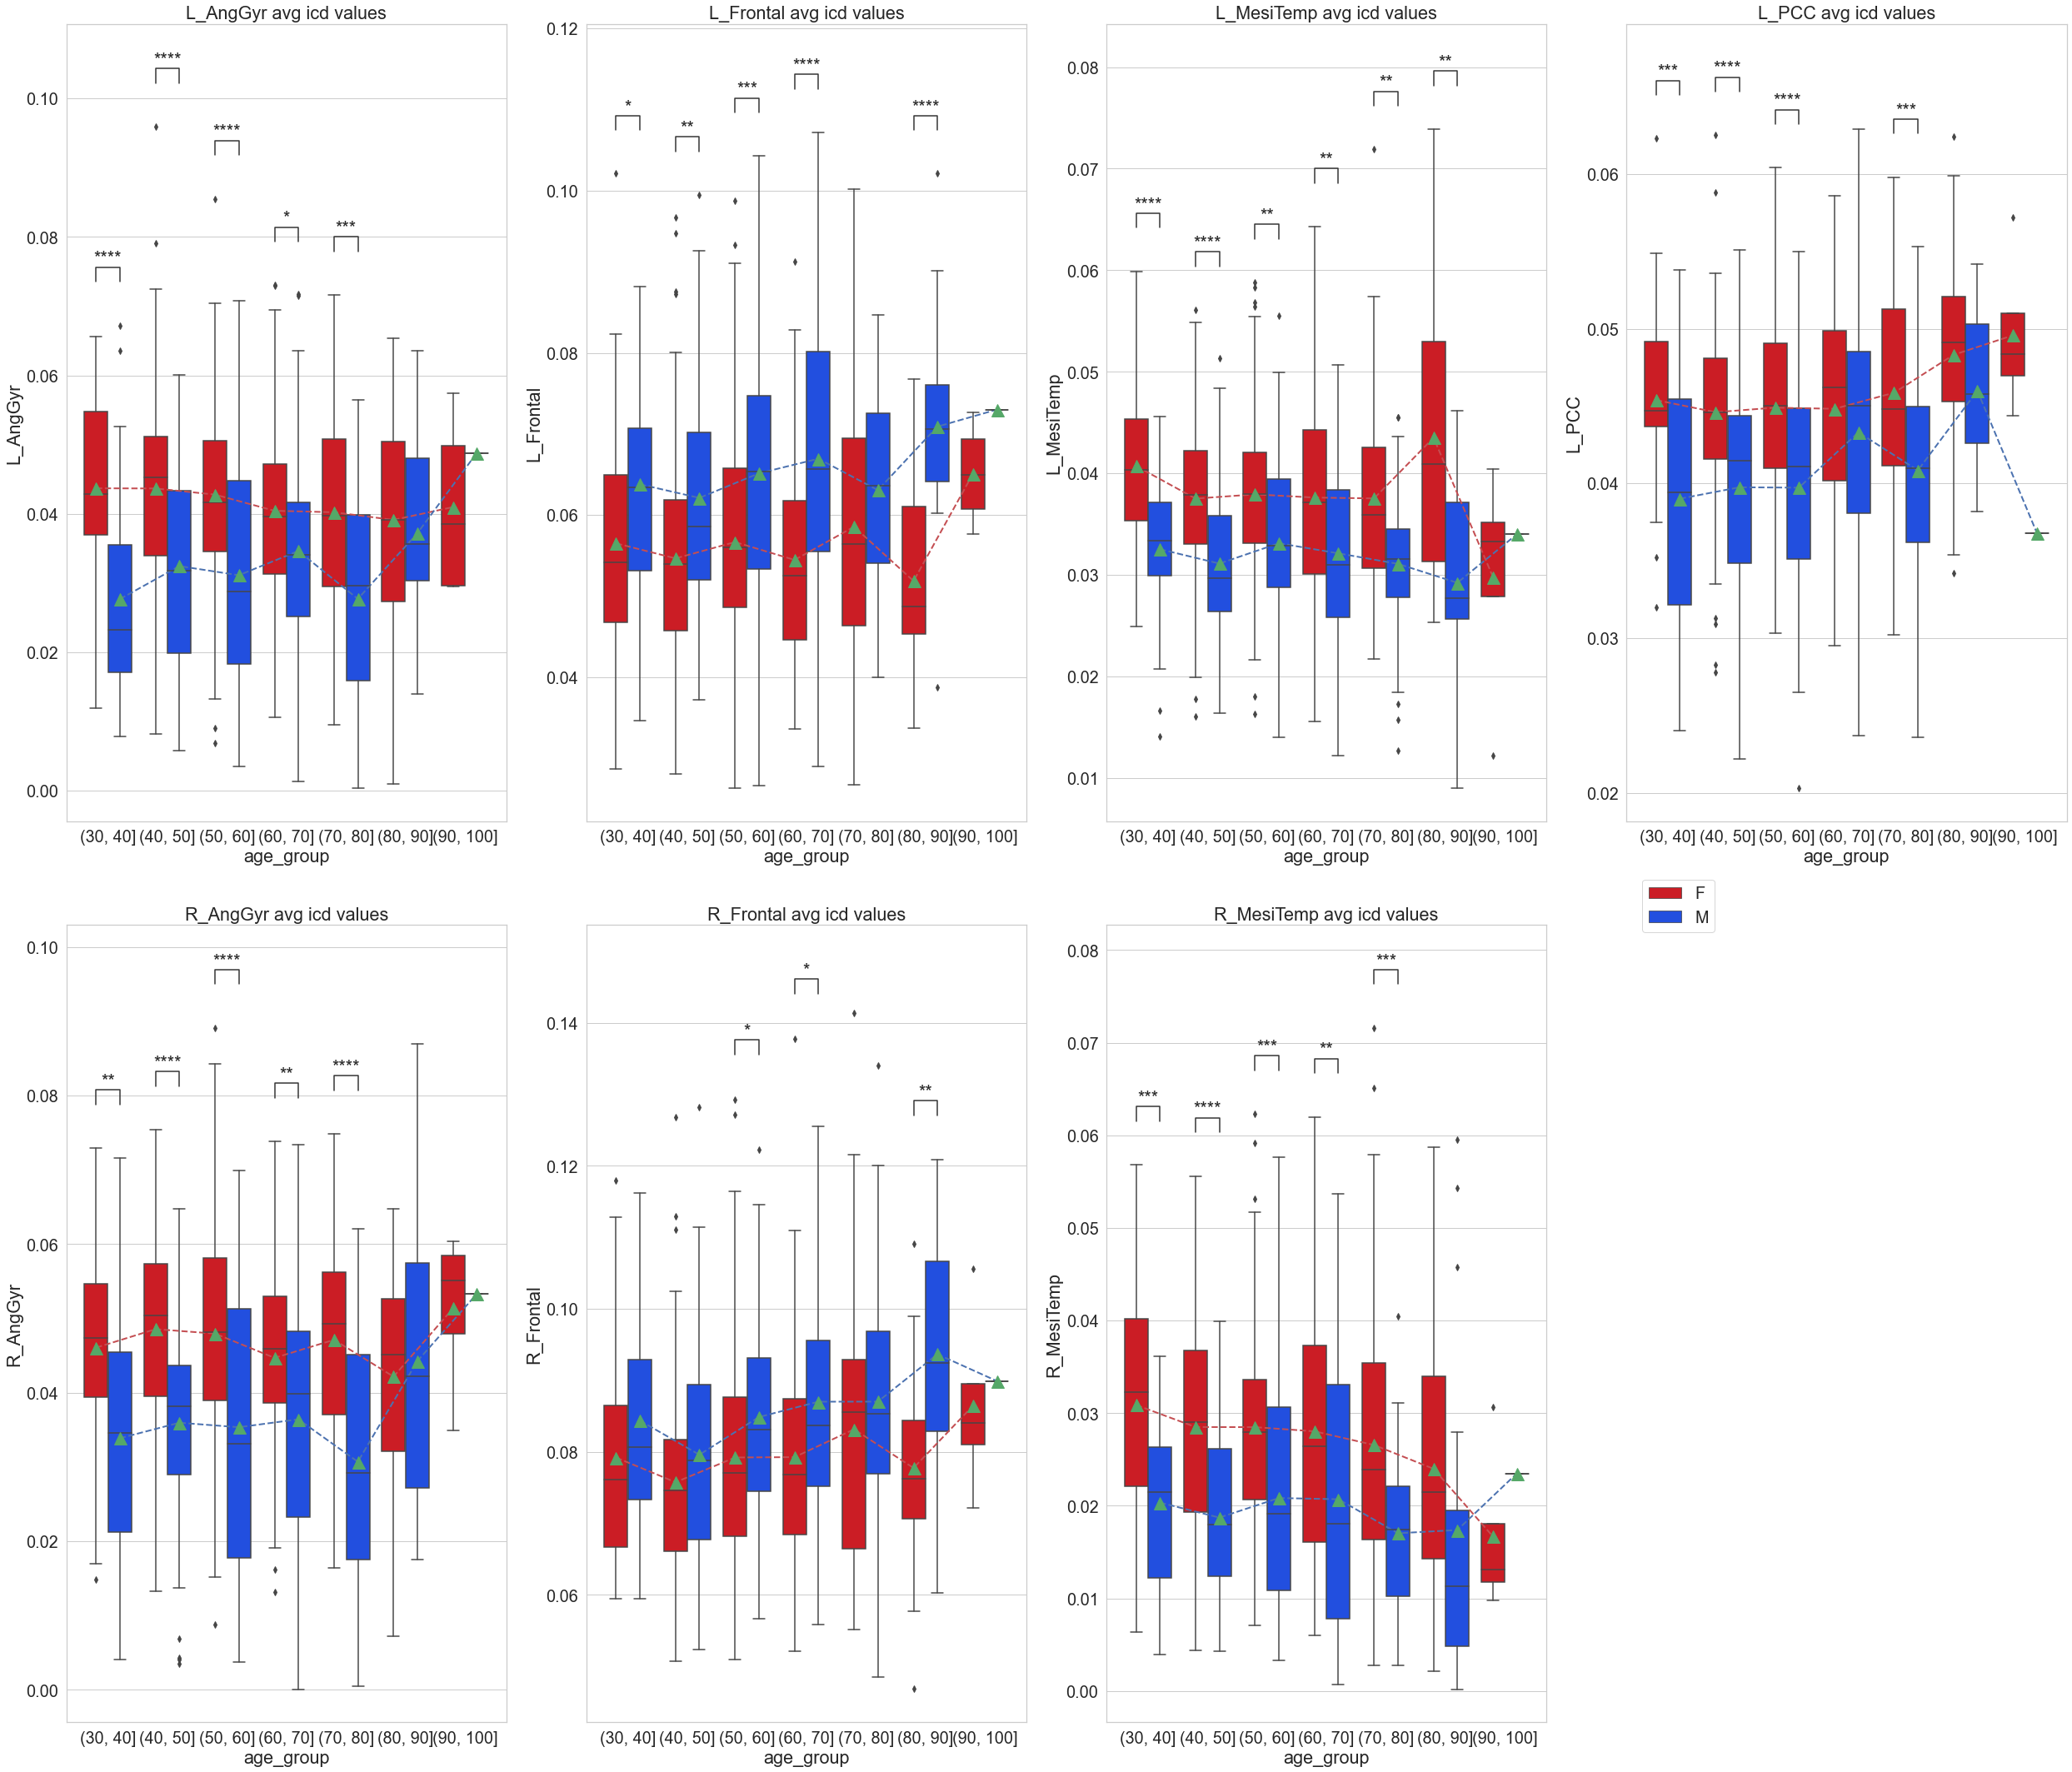

In [112]:
# sns.set(font_scale = 2)
# sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize = [35,30])

plt.subplot(241)
conn_vs_age_boxplot(master_data_avg_icd, "L_AngGyr", "icd", L_AngGyr_box_pairs)
plt.subplot(245)
conn_vs_age_boxplot(master_data_avg_icd, "R_AngGyr", "icd", R_AngGyr_box_pairs)

plt.subplot(242)
conn_vs_age_boxplot(master_data_avg_icd, "L_Frontal", "icd", L_Frontal_box_pairs)
plt.subplot(246)
conn_vs_age_boxplot(master_data_avg_icd, "R_Frontal", "icd", R_Frontal_box_pairs)

plt.subplot(243)
conn_vs_age_boxplot(master_data_avg_icd, "L_MesiTemp", "icd", L_MesiTemp_box_pairs)
plt.subplot(247)
conn_vs_age_boxplot(master_data_avg_icd, "R_MesiTemp", "icd", R_MesiTemp_box_pairs)

plt.subplot(244)
conn_vs_age_boxplot(master_data_avg_icd, "L_PCC", "icd", L_PCC_box_pairs)

plt.legend(loc='lower right', bbox_to_anchor=(0.22, -0.15))

plt.tight_layout()

In [17]:
ttest_icd = pd.DataFrame(columns = ['age_group', 'ROI', 't value', 'p value'])

### Perform t-test between women and men by decade and collect t scores and p values (performed without Bonferroni correction!)

In [18]:
# perform t-test to compared L_PCC values between women and men by decade
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, "L_PCC", "icd"))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, "L_AngGyr", "icd"))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, "R_AngGyr", "icd"))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, "L_Frontal", "icd"))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, "R_Frontal", "icd"))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, "L_MesiTemp", "icd"))
ttest_icd = ttest_icd.append(ttest_age(master_data_avg_icd, "R_MesiTemp", "icd"))

### Write all t-test values (stored in ttest_icd dataframe) into a .txt file

In [19]:
# write age groups, t values, and p values to a .txt file
ttest_icd.to_csv('data/ttest_icd.txt')
print(ttest_icd)

  age_group         ROI   t value       p value
0     30_40       L_PCC  3.825511  3.021395e-04
1     40_50       L_PCC  4.454953  1.644745e-05
2     50_60       L_PCC  4.522817  1.344261e-05
3     60_70       L_PCC  1.033571  3.037115e-01
4     70_80       L_PCC  3.587778  5.475851e-04
5     80_90       L_PCC  1.181180  2.441767e-01
6    90_100       L_PCC       NaN           NaN
0     30_40    L_AngGyr  4.519083  2.794813e-05
1     40_50    L_AngGyr  4.449263  1.683628e-05
2     50_60    L_AngGyr  4.355679  2.640834e-05
3     60_70    L_AngGyr  2.112287  3.703339e-02
4     70_80    L_AngGyr  3.812894  2.543511e-04
5     80_90    L_AngGyr  0.427067  6.715122e-01
6    90_100    L_AngGyr       NaN           NaN
0     30_40    R_AngGyr  3.262095  1.787628e-03
1     40_50    R_AngGyr  5.465353  1.913943e-07
2     50_60    R_AngGyr  4.422231  2.022283e-05
3     60_70    R_AngGyr  2.901320  4.527718e-03
4     70_80    R_AngGyr  5.037280  2.493129e-06
5     80_90    R_AngGyr -0.396493  6.937

### Generate plot to visualize all t values

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


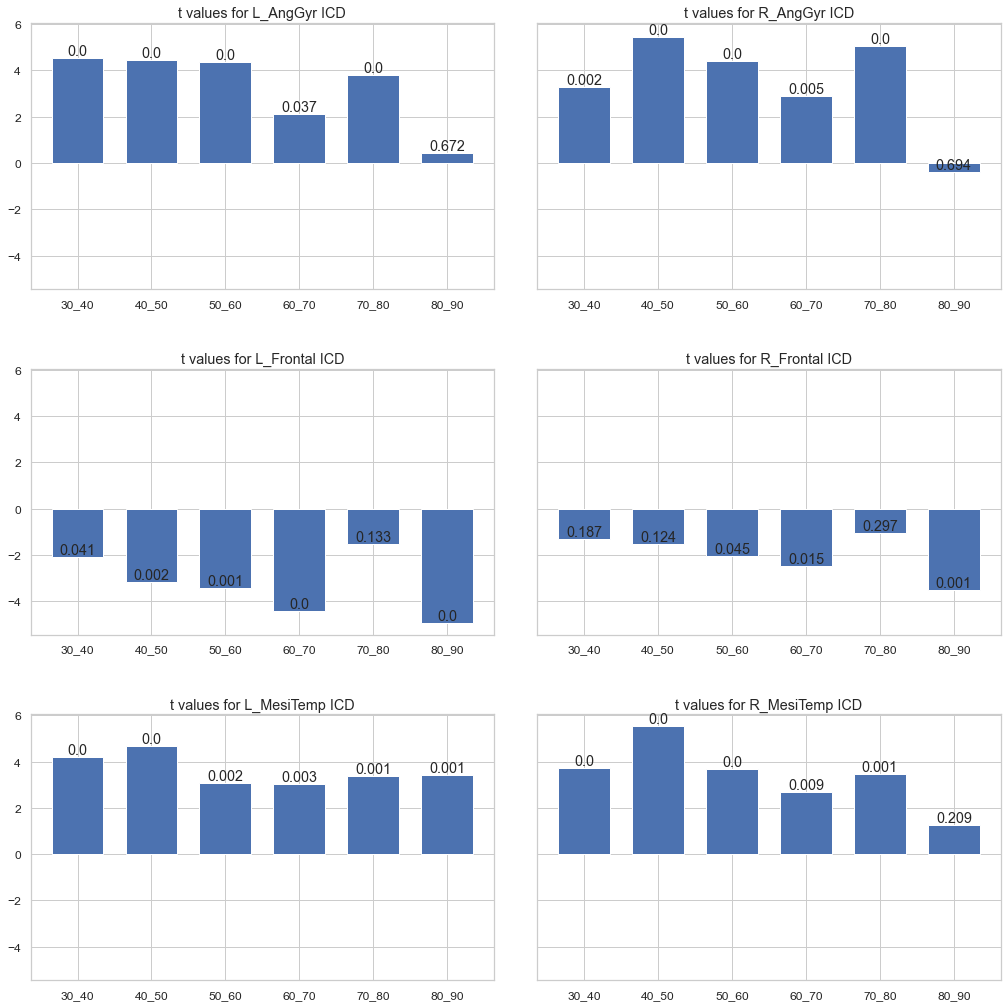

In [20]:
fig, axs = plt.subplots(3, 2, figsize = [15,15], sharey=True)
sns.set(font_scale = 1.2)
axs[0, 0].bar(ttest_icd[ttest_icd['ROI'] == 'L_AngGyr']['age_group'], ttest_icd[ttest_icd['ROI'] == 'L_AngGyr']['t value'], width = 0.7)
axs[0, 0].set_title("t values for L_AngGyr ICD")
axs[0, 1].bar(ttest_icd[ttest_icd['ROI'] == 'R_AngGyr']['age_group'], ttest_icd[ttest_icd['ROI'] == 'R_AngGyr']['t value'], width = 0.7)
axs[0, 1].set_title("t values for R_AngGyr ICD")
axs[1, 0].bar(ttest_icd[ttest_icd['ROI'] == 'L_Frontal']['age_group'], ttest_icd[ttest_icd['ROI'] == 'L_Frontal']['t value'], width = 0.7)
axs[1, 0].set_title("t values for L_Frontal ICD")
axs[1, 1].bar(ttest_icd[ttest_icd['ROI'] == 'R_Frontal']['age_group'], ttest_icd[ttest_icd['ROI'] == 'R_Frontal']['t value'], width = 0.7)
axs[1, 1].set_title("t values for R_Frontal ICD")
axs[2, 0].bar(ttest_icd[ttest_icd['ROI'] == 'L_MesiTemp']['age_group'], ttest_icd[ttest_icd['ROI'] == 'L_MesiTemp']['t value'], width = 0.7)
axs[2, 0].set_title("t values for L_MesiTemp ICD")
axs[2, 1].bar(ttest_icd[ttest_icd['ROI'] == 'R_MesiTemp']['age_group'], ttest_icd[ttest_icd['ROI'] == 'R_MesiTemp']['t value'], width = 0.7)
axs[2, 1].set_title("t values for R_MesiTemp ICD")

rects = axs[0, 0].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'L_AngGyr']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[0, 0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[0, 1].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'R_AngGyr']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[0, 1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[1, 0].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'L_Frontal']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[1, 0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[1, 1].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'R_Frontal']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[1, 1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[2, 0].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'L_MesiTemp']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[2, 0].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
rects = axs[2, 1].patches
labels = round(ttest_icd[ttest_icd['ROI'] == 'R_MesiTemp']['p value'], 3)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[2, 1].text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")
    
fig.tight_layout(pad = 3)
plt.savefig('figures/ICD t values')

### Generate heatmap of gender difference across ROI (in this figure, we use t scores as the difference measure)

age_group      30_40     40_50     50_60     60_70     70_80     80_90
ROI                                                                   
L_PCC       3.825511  4.454953  4.522817  1.033571  3.587778  1.181180
L_AngGyr    4.519083  4.449263  4.355679  2.112287  3.812894  0.427067
R_AngGyr    3.262095  5.465353  4.422231  2.901320  5.037280 -0.396493
L_Frontal  -2.083220 -3.182601 -3.450061 -4.405831 -1.517020 -4.928238
R_Frontal  -1.332783 -1.546244 -2.028094 -2.483548 -1.048472 -3.514362
L_MesiTemp  4.205769  4.696041  3.095427  3.046188  3.365252  3.419171
R_MesiTemp  3.719510  5.518074  3.665126  2.676812  3.481546  1.276876


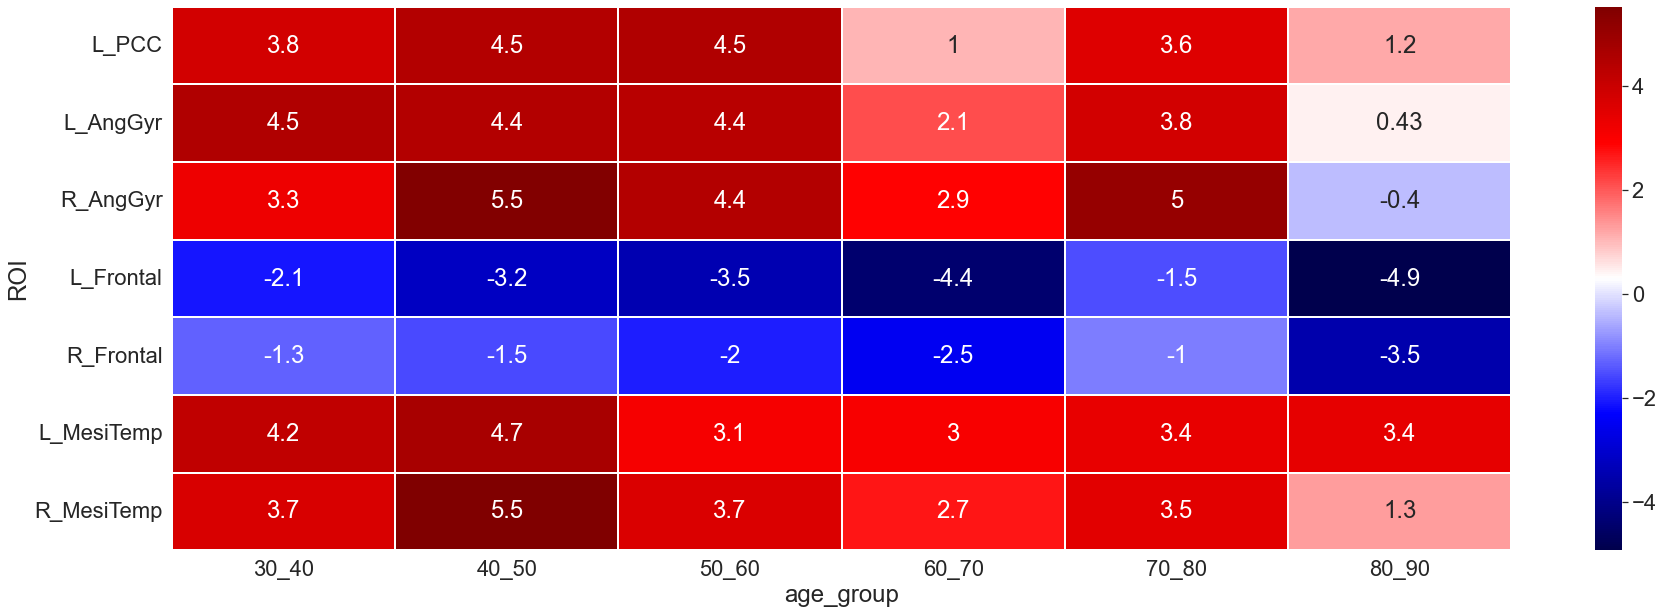

In [36]:
ttest_icd_new = ttest_icd[ttest_icd["age_group"] != "90_100"].pivot("ROI", "age_group", "t value")
ttest_icd_new = ttest_icd_new.reindex(["L_PCC", "L_AngGyr", "R_AngGyr", "L_Frontal", "R_Frontal", "L_MesiTemp", "R_MesiTemp"])
print(ttest_icd_new)
sns.set(rc={"figure.figsize":(30,10)})
sns.set(font_scale = 2)
ax = sns.heatmap(ttest_icd_new, cmap = 'seismic', linewidth = 0.1, annot = True)
plt.savefig("figures/fig3_heatmap_ROIvsAge_tscores.png")

### ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////